In [1]:
import numpy as np
from scipy.spatial import Delaunay
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [63]:
def generate_smiley(points, noise_factor=0.01):
    '''
    Input: an amount of points to generate and a noise factor that controls how much the points are scattered
    Output: a numpy array containing the coordinates of the points in the pattern of a smiley face
    '''
    #generating the points: the components of the face are scaled with a certain factor and shifted
    face_circle = np.array([[np.cos(theta), np.sin(theta)] for theta in np.linspace(0, 2 * np.pi, points)])[:-1].copy()
    left_eye = np.array([[0.2 * np.cos(theta) - 0.37, 0.2 * np.sin(theta) + 0.2] for theta in np.linspace(0, 2 * np.pi, points)])[:-1].copy()
    right_eye = np.array([[0.2 * np.cos(theta) + 0.37, 0.2 * np.sin(theta) + 0.2] for theta in np.linspace(0, 2 * np.pi, points)])[:-1].copy()
    smile = np.array([[0.8 * np.cos(theta), 0.4 * np.sin(theta) - 0.8] for theta in np.linspace(0.4 * np.pi, 0.6 * np.pi, points)])
    
    #adding noise
    noise = np.random.normal(scale=noise_factor, size=(len(face_circle), 2))
    face_circle += noise
    noise = np.random.normal(scale=noise_factor, size=(len(left_eye), 2))
    left_eye += noise
    noise = np.random.normal(scale=noise_factor, size=(len(right_eye), 2))
    right_eye += noise
    noise = np.random.normal(scale=noise_factor, size=(len(smile), 2))
    smile += noise
    
    return np.concatenate([face_circle, left_eye, right_eye, smile])

def generate_spiral(num_points, turns=2, noise_factor=0.01):
    '''
    Input: an amount of points to generate, the number of turns of the spiral and a noise factor that controls how much the points are scattered
    Output: a numpy array containing the coordinates of the points in the pattern of a spiral
    '''
    #the spiral is scaled by a certain factor
    theta = np.linspace(0, 2 * np.pi * turns, num_points)
    radius = theta
    x = radius * np.cos(theta) * 0.1
    y = radius * np.sin(theta) * 0.1

    #adding noise
    noise = np.random.normal(scale=noise_factor, size=(len(x), 2))
    x += noise[:, 0]
    y += noise[:, 1]

    spiral_points = np.column_stack((x, y))
    return spiral_points

In [64]:
def plot_points(points):
    '''
    Input: a numpy array of point coordinates
    Output: a scatter plot of the points
    '''
    plt.scatter(points[:, 0], points[:, 1], s=5, c='blue')
    plt.title('Point dataset')
    plt.show()

def delaunay_triangulation(points):
    '''
    Input: a numpy array of point coordinates
    Output: a Delaunay triangulation plot
    '''
    tri = Delaunay(points)
    plt.triplot(points[:,0], points[:,1], tri.simplices)
    plt.title('Delaunay Graph')
    plt.show()

def rdg_compute(points, threshold=1.65):
    '''
    Input: a numpy array of point coordinates and a threshold
    Output: a Reduced Delaunay Graph plot
    '''
    if(threshold <= 0):
        print("Threshold has to be positive")
        return
    
    tri = Delaunay(points)
    result_edge_map = {}

    def min_distance_between_neighbors(point, points, tri, i):
        '''
        Helper function for rdg_compute
        Input: a point, a numpy array of point coordinates, a Delaunay triangulation and the index of the point
        Output: the minimum distance between the point and its neighbors, the neighbors themselves and all the distances between the point and the neighbors
        '''
        #find the indices of neighboring vertices for the current point
        simplex_indices = np.where(np.any(tri.simplices == i, axis=1))[0]
        neighbor_indices = np.unique(tri.simplices[simplex_indices])
        neighbors = points[neighbor_indices]

        #calculate distances between the  vertices and return the minimum between them
        distances = np.linalg.norm(neighbors - point, axis=1)
        return np.min(distances[distances > 0]), neighbors, distances

    #looping through all the points, calculate a value for each edge (geometric average between two distance ratios) and store it in a map
    for i, point in enumerate(points):
        #calculate the minimum distance between the current point and its neighbors
        min_distance1, neighbors, distances = min_distance_between_neighbors(point, points, tri, i)

        for neighbor, distance in zip(neighbors, distances):
            if distance > 0:
                #first ratio: distance between the current point and its neighbor divided by the minimum distance between the current point and its neighbors
                ratio1 = distance / min_distance1

                #second ratio: distance between the current point and its neighbor divided by the minimum distance between the neighbor and its neighbors
                min_distance2, _, _ = min_distance_between_neighbors(neighbor, points, tri, i)
                ratio2 = distance / min_distance2

                #geometric average between the two ratios
                result = np.sqrt(ratio1 * ratio2)

                #store the result in a map with the associated edge as the key
                edge = tuple(sorted((tuple(point), tuple(neighbor)), key=lambda x: (x[0], x[1])))
                result_edge_map[edge] = result

    
    #Attempt at calculating a dynamic threshold for the results as the average of all of them
    total_sum = 0
    count = 0
    for value in result_edge_map.values():
        if isinstance(value, (int, float)):
            total_sum += value
            count += 1
    threshold = (total_sum / count)

    def minimum_enclosing_circle_area(points):
        '''
        Helper function for rdg_compute
        Input: a numpy array of point coordinates
        Output: the area of the minimum enclosing circle of the points
        '''
        hull = ConvexHull(points)
        center = np.mean(points[hull.vertices], axis=0)
        radius = np.max(np.linalg.norm(points[hull.vertices] - center, axis=1))
        area = np.pi * radius**2
        return area
    threshold = minimum_enclosing_circle_area(points)
    
    print(f"Dynamic computed threshold: {threshold}")
    
    #threshold = 2

    #eliminate all the edges with an associated value greater than the threshold
    result_edge_map = {key: value for key, value in result_edge_map.items() if not (isinstance(value, (int, float)) and value >= threshold)}
    
    #plotting
    for edge, result in result_edge_map.items():
        #print(f"Edge: {edge} -> Result: {result}")
        edge_array = np.array(edge)
        plt.plot(edge_array[:, 0], edge_array[:, 1], color='blue')
    plt.title('Reduced Delaunay Graph')
    plt.show()

def kmeans_clustering(points, n_clusters):
    '''
    Input: a numpy array of point coordinates and the number of desired clusters
    Output: a K-means Clustering plot
    '''
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(points)

    #create a grid to plot the decision boundaries that separate the clusters
    x_min, x_max = points[:, 0].min() - 1, points[:, 0].max() + 1
    y_min, y_max = points[:, 1].min() - 1, points[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                        np.arange(y_min, y_max, 0.02))

    #predicting clusters
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    #plotting
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(points[:, 0], points[:, 1], c=kmeans.labels_, s=25, cmap='viridis', edgecolors='k')
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=10, alpha=0.9, marker='X')
    plt.title('K-means Clustering')
    plt.show()

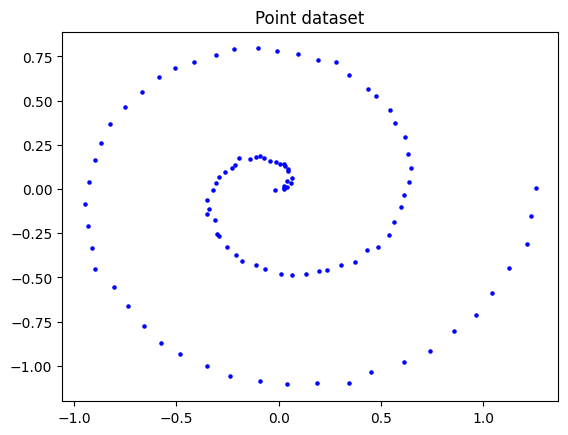

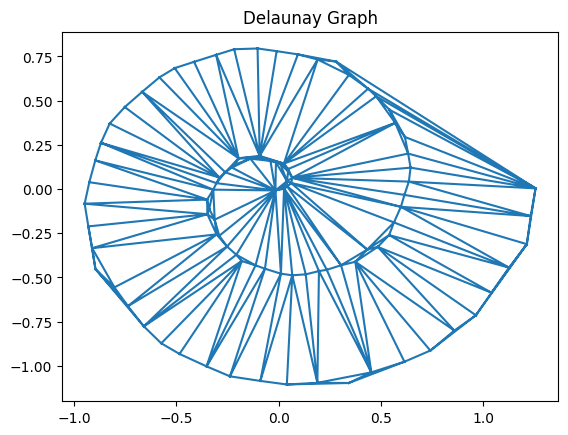

Dynamic computed threshold: 6.834953607241764


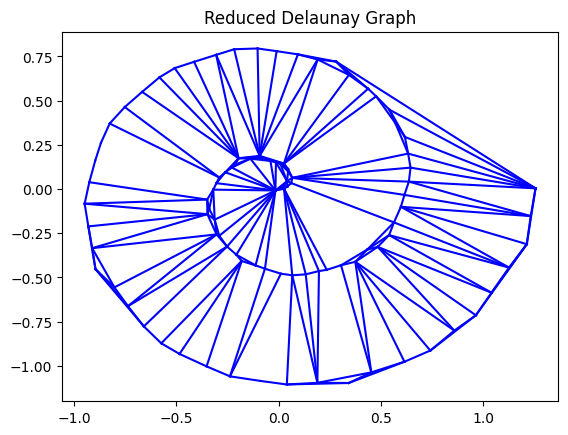

C:\Users\Teo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


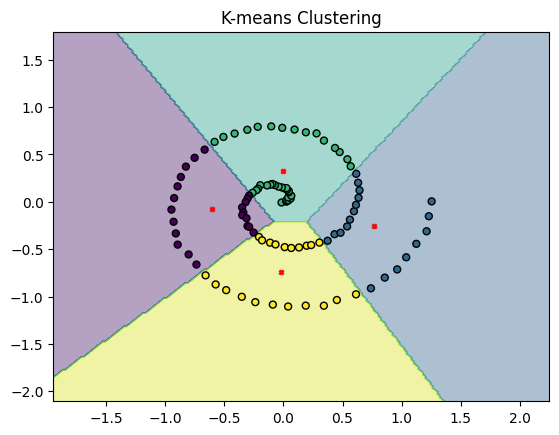

In [65]:
#example datasets
#points = np.array([[-1, -1], [-1, -0.75], [-0.75, -0.75], [-0.75, -1], [1, 1], [1, 0.75], [0.75, 0.75], [0.75, 1], [-1, 1], [-1, 0.75], [-0.75, 0.75], [-0.75, 1], [1, -1], [1, -0.75], [0.75, -0.75], [0.75, -1]])
#points = generate_smiley(100)
points = generate_spiral(100)

plot_points(points)
delaunay_triangulation(points)
rdg_compute(points, 2.5)
kmeans_clustering(points, 4)